In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42

from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("../../ScientificColourMaps7/batlow/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list('batlow', cm_data)

cm_data = np.loadtxt("../../ScientificColourMaps7/bamako/bamako.txt")[::-1]
bamako_map = LinearSegmentedColormap.from_list('bamako', cm_data)

import cartopy.crs as ccrs
import regionmask

### Preliminaries

In [3]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict, gardsv_ssp_dict, gardsv_var_dict, deepsdbc_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if 'pr' in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

## Historical quantile comparisons

## Metrics time series plots

In [25]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/'
path_out = '/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/figs/supplementary/'

In [26]:
def make_metric_plot(ensemble, models, path_in, metric, var_id, out_path):
    ssp_colors = {'ssp126':'#8da0cb',
                  'ssp245':'#fc8d62',
                  'ssp370':'#66c2a5',
                  'ssp585':'#e78ac3'}

    fig, axs = plt.subplots(nrows=11, ncols=4, figsize=(15,30), sharex=True)
    axs = axs.flatten()

    for idx, region in enumerate(regionmask.defined_regions.ar6.land.names[:-2]):
        key = regionmask.defined_regions.ar6.land.map_keys(region)
        for model in models[:2]:
            # Read netcdf or zarr
            if ensemble in ['nex-gddp', 'isimip3b', 'GARD-SV']:
                ds = xr.open_dataset(path_in + ensemble + '/' + metric + '/' + model + '.nc')
            elif ensemble in ['cil-gdpcir', 'DeepSD-BC']:
                ds = xr.open_dataset(path_in + ensemble + '/' + metric + '/' + model, engine='zarr')
            # Select variable
            ds = ds[var_id]
            # Mask region
            mask = regionmask.defined_regions.ar6.land.mask(ds)
            # Plot by ssp
            for ssp in nex_ssp_dict[model]:
                yrs = ds.sel(ssp=ssp).time.dt.year
                axs[idx].plot(yrs, ds.sel(ssp=ssp).where(mask == key).mean(dim=['lat','lon']).to_numpy(), lw=1, color=ssp_colors[ssp])
                axs[idx].set_title(region)

    plt.savefig(out_path + ensemble + '_' + metric + '_' + var_id + '.png', dpi=300)

In [ ]:
# All combinations: avg
metric = 'avg'

delayed_res = []

delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', nex_models, path_in, metric, 'tas', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', nex_models, path_in, metric, 'tasmin', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', nex_models, path_in, metric, 'tasmax', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', nex_models, path_in, metric, 'pr', out_path))

delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', cil_models, path_in, metric, 'tas', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', cil_models, path_in, metric, 'tasmin', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', cil_models, path_in, metric, 'tasmax', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', cil_models, path_in, metric, 'pr', out_path))

delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', cbp_gard_models, path_in + 'carbonplan/regridded/conservative/', metric, 'tas', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', cbp_gard_models, path_in + 'carbonplan/regridded/conservative/', metric, 'tasmin', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', cbp_gard_models, path_in + 'carbonplan/regridded/conservative/', metric, 'tasmax', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', cbp_gard_precip_models, path_in + 'carbonplan/regridded/conservative/', metric, 'pr', out_path))

delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', cbp_deep_models, path_in + 'carbonplan/regridded/conservative/', metric, 'tas', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', cbp_deep_models, path_in + 'carbonplan/regridded/conservative/', metric, 'tasmin', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', cbp_deep_models, path_in + 'carbonplan/regridded/conservative/', metric, 'tasmax', out_path))
delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', cbp_deep_models, path_in + 'carbonplan/regridded/conservative/', metric, 'pr', out_path))

# Compute
res = dask.compute(*delayed_res)

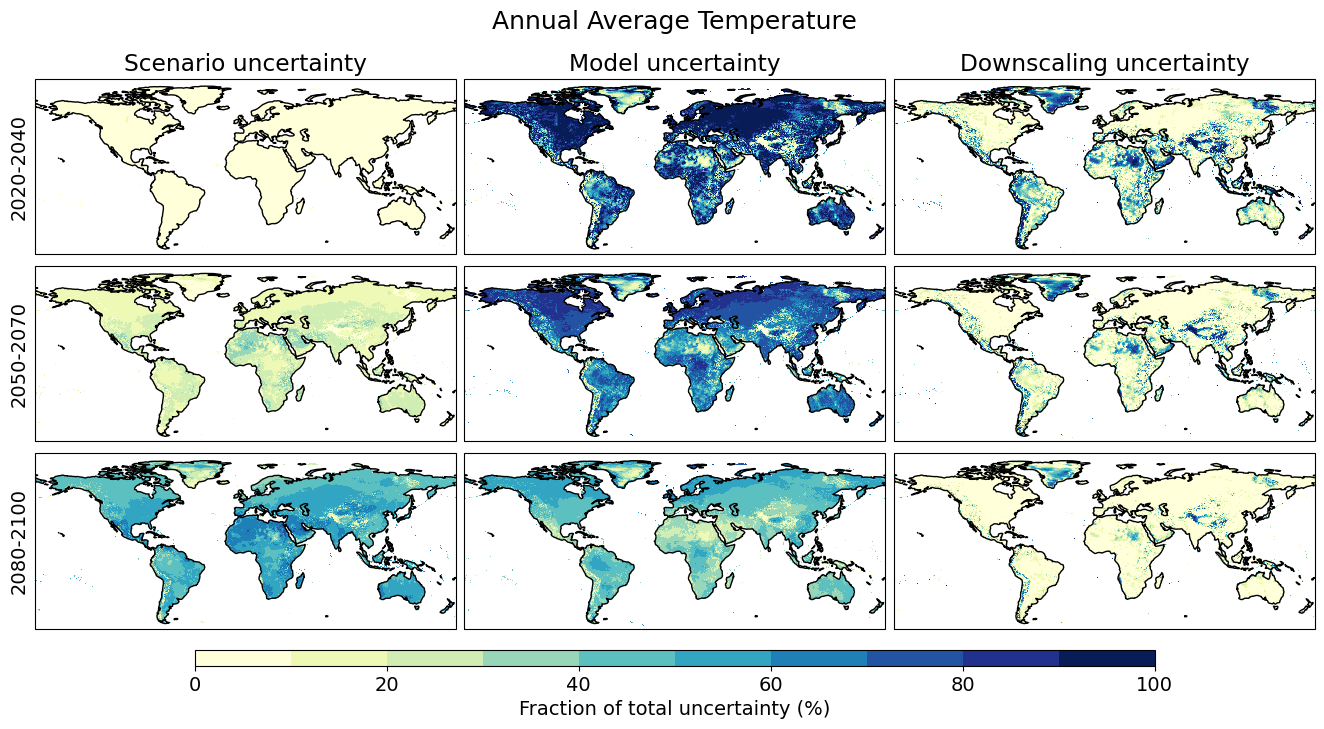

In [24]:
plot_map(ds, 'tas', 'Annual Average Temperature', 'tas_avg_hs09_map')

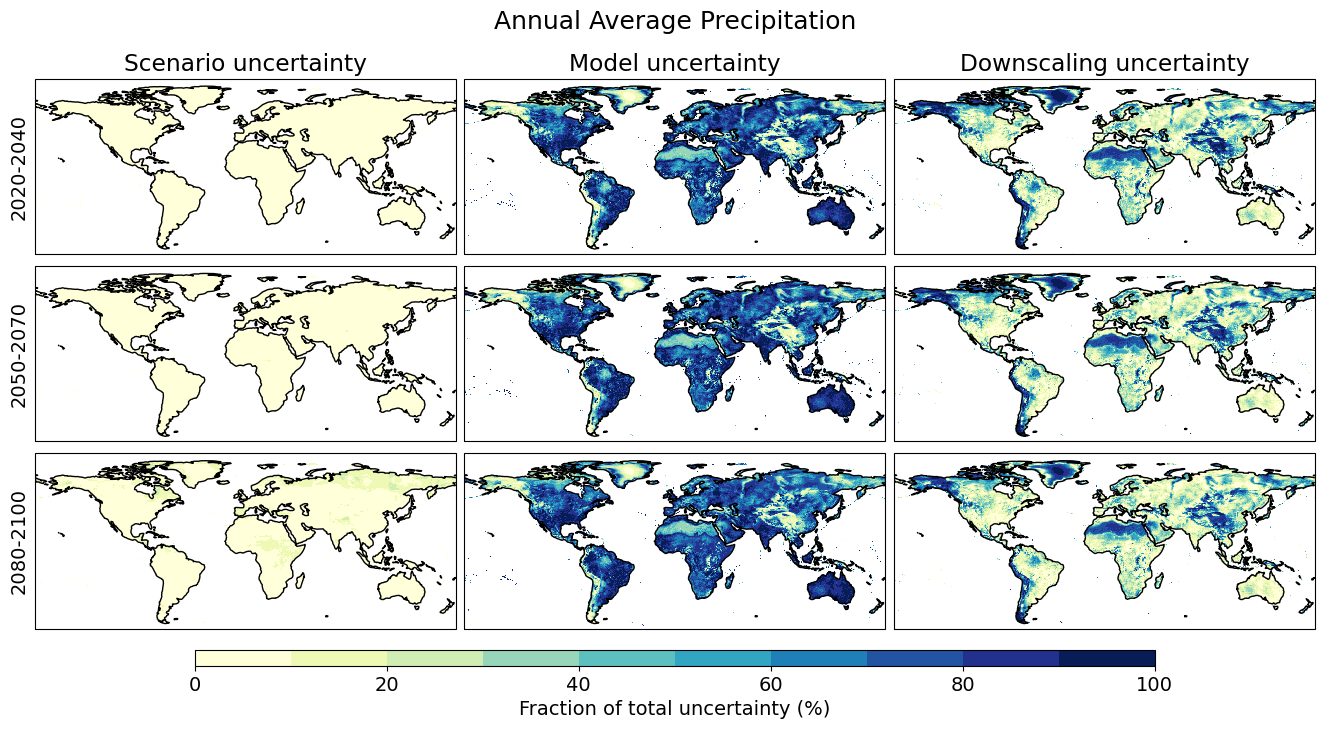

In [25]:
plot_map(ds, 'pr', 'Annual Average Precipitation', 'pr_avg_hs09_map')